In [40]:
import numpy as np
from gc_utils import *
from plot_utils import *
from datetime import datetime
from sklearn.preprocessing import PolynomialFeatures

In [41]:
def initialization(X,Y,hidden_layers,hidden_size):
    params ={}
    models = {}
    models['W1'] = np.random.randn( hidden_size[0],X.shape[1] + 1 )
    for i in range(2,hidden_layers+2):
        models['W'+str(i)] = np.random.randn( hidden_size[i-1] , models['W'+str(i-1)].shape[0] + 1 )
    
    params['X'] = X
    params['Y'] = Y
    
    return params,models

In [42]:
def feature_normalize(X):
    X_mean = np.mean(X)
    X_std = np.std(X)
    X_norm = (X-X_mean)/X_std
    
    return X_norm

In [43]:
def compute_cost(params,models,hidden_layers,lambd):
    m = params['X'].shape[0]
      
    J = np.sum( y*np.log(params['Y_hat']) + (1-y)*np.log(1-params['Y_hat']) )/-m
    regularized_term = 0
    for i in range(1,hidden_layers+2):
        regularized_term += np.sum( np.power( models['W'+str(i)][:,1:] , 2 ) ) 

    J = J + (lambd/(2*m))*regularized_term

    return J

In [44]:
def forward_propagation(params,models,hidden_layers):
    
    params['A1'] = params['X']
    for i in range(1,hidden_layers+2):
        params['A'+str(i)] = np.column_stack( (np.ones(( params['A'+str(i)].shape[0] , 1)) , params['A'+str(i)]) )
        params['Z'+str(i+1)] = np.dot( params['A'+str(i)] , models['W'+str(i)].transpose()  )
        params['A'+str(i+1)] = sigmoid( params['Z'+str(i+1)] )
        
    params['Y_hat'] = params['A'+str(hidden_layers+2)]
    
    return params

In [45]:
def backward_propagation(params,model,hidden_layers,lambd,alpha):
    m = params['Y'].shape[0]
    gradients = {}
    gradients['delta'+str(hidden_layers+2)] = params['Y_hat'] - params['Y']

    for i in range(hidden_layers+1,1,-1):
        delta = gradients['delta'+str(i+1)]
        if i == hidden_layers+1:
            delta = delta.transpose()
        gradients['delta'+str(i)] = np.dot( model['W'+str(i)][:,1:].transpose() , delta ) * \
            sigmoid_gradient(params['Z'+str(i)]).transpose()
    
    for i in range(1,hidden_layers+2):
        delta = gradients['delta'+str(i+1)]
        if i == hidden_layers+1:
            delta = delta.transpose()

        gradients['dW'+str(i)] = np.dot( delta , params['A'+str(i)] )/m + \
            (lambd/m)*np.column_stack( (np.zeros((model['W'+str(i)].shape[0],1)) , model['W'+str(i)][:,1:]) )
        
        model['W'+str(i)] -= alpha*gradients['dW'+str(i)] 
        
    return params,model,gradients

In [46]:
def gradient_checking(params,models,gradients,epsilon,hidden_layers,lambd):
    
    parameters_values = dictionary_to_vector(models,hidden_layers)
    grad = gradients_to_vector(gradients,hidden_layers)
    num_parameters = parameters_values.shape[0]
    J_plus = np.zeros((num_parameters, 1))
    J_minus = np.zeros((num_parameters, 1))
    gradapprox = np.zeros((num_parameters, 1))
        
    for i in range(num_parameters):       
        thetaplus = np.copy(parameters_values)                                     
        thetaplus[i] = thetaplus[i] + epsilon                                      
        models = vector_to_dictionary(models,thetaplus,hidden_layers)
        params= forward_propagation( params,models, hidden_layers)                                 
        J_plus[i] = compute_cost(params,models,hidden_layers,lambd)
        
        thetaminus = np.copy(parameters_values)                                
        thetaminus[i] = thetaminus[i] - epsilon                             
        models = vector_to_dictionary(models,thetaminus,hidden_layers)
        params= forward_propagation( params,models, hidden_layers)                                 
        J_minus[i] = compute_cost(params,models,hidden_layers,lambd)                                  
    
        gradapprox[i] = (J_plus[i] - J_minus[i])/(2*epsilon)
        thetaplus[i] = thetaplus[i] - epsilon 
    
    numerator = np.power(grad - gradapprox,2)                                           
    denominator = np.power(grad,2) + np.power(gradapprox,2)                                         
    difference = numerator/(denominator+1e-8)                                        
      
    if difference.any() > 2e-4:
        print ("\033[93m" + "There is may a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
    else:
        print ("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")
    
    return gradapprox,difference   

In [47]:
def model(params,models,hidden_layers,hidden_size,lamdb,alpha,iter_times):
  
    J_history = []
    for i in range(iter_times):    
        params = forward_propagation(params,models,hidden_layers)
        J = compute_cost(params,models,hidden_layers,lambd)
        params,models,gradients = backward_propagation(params,models,hidden_layers,lambd=lambd,alpha=0.01)
        
        J_history.append(J)

    
    return models,J_history,gradients

In [48]:
def prediction(model,X,hidden_layers):
    params = {}
    params['X'] = X
    res = forward_propagation(params,model,hidden_layers)
    
    Y_hat  = res['Y_hat']
    predict = np.argmax(Y_hat,axis=1)
    predict = np.array(predict).reshape( Y_hat.shape[0] ,1 )
    
    return predict

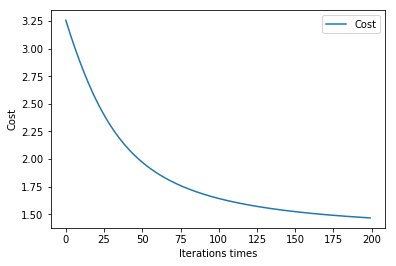

time:0:00:01.062061


In [69]:
"""
    初始化参数,训练model
"""
start = datetime.now()
X,Y = read('2',2)

poly = PolynomialFeatures(10)
X = poly.fit_transform(X)

X = feature_normalize(X)

hidden_layers = 3
K = [0,1,2,3]
y = np.zeros( (X.shape[0] ,  len(K) ) )
for i,j in enumerate(K):
    y[:,i] = j
y = y == Y

hidden_size = [25,25,10,y.shape[1]]
lambd = 0
alpha = 0.5
iter_times = 200
epsilon = 1e-7
params,models = initialization(X,y,hidden_layers,hidden_size)


models,J_history,gradients  = model(params,models,hidden_layers = hidden_layers,hidden_size = hidden_size, lamdb = lambd
                        ,alpha=alpha,iter_times=iter_times)
#gradient_checking(params,models,gradients,epsilon,hidden_layers,lambd)
plot_learning_curve(J_history)
end = datetime.now()
print('time:'+str(end-start))

In [70]:
"""
    在训练集上的效果
"""
predict = prediction(models,X,hidden_layers)
res = predict == Y

print('accuracy:{} %'.format( (np.sum(res)/res.shape[0])*100 ) )

accuracy:75.36231884057972 %


In [71]:
"""
    在测试集上的效果
"""
test_X,test_Y = read('1',2)
poly = PolynomialFeatures(10)
test_X = poly.fit_transform(test_X)
test_X = feature_normalize(test_X)
predict = prediction(models,test_X,hidden_layers)
res = predict == test_Y

print('accuracy:{} %'.format( (np.sum(res)/res.shape[0])*100 ) )

accuracy:69.81132075471697 %
